# SVM Optimization

## Linearized L1

### Model Formulation

#### Sets

* $N$: indices of data points.

* $M$: indices of variables.


#### Parameters

- $p_{n, m}$: _data points_, $\forall n\in N, m \in M$
- $y_{n}$: _label_, $y_{n} \in  \{0,1\}, \forall n \in N$

#### Decision Variables

- $w_{m}^{+}$: Vector of positive values for SVM hyperplane. $W_{m}^{}$
- $w_{m}^{-}$: Vector of negative values for SVM hyperplane.
- $b$: Sesgo del hiperplano.

#### Objective Function

Minimize l1 norm:

$$
    \min \sum_{m \in M}w_{m}^{+} + w_{m}^{-}
$$

#### Constraints

$$
    y_{n} \cdot \left(\sum_{m\in M}(w_{m}^{+} - w_{m}^{-}) \cdot p_{n, m} - b\right) \leq 1,\ \forall n \in N
$$

### Python Implementation

#### Generate blobs

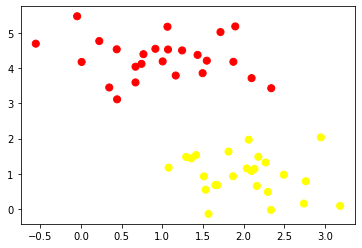

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

p, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
fig, ax = plt.subplots()
ax.scatter(p[:, 0], p[:, 1], c=y, s=50, cmap='autumn')

#### Minimize $w$ margin by solving model

In [11]:
import gurobipy as gp
from gurobipy import GRB, quicksum

M = set(range(len(p[0, :])))
N = set(range(len(y)))

# Create an empty model
model_lp = gp.Model('SVM_LP')

# Add variables
w_pos = {m: model_lp.addVar(vtype=GRB.CONTINUOUS, name=f"w_pos_{m}") for m in M}
w_neg = {m: model_lp.addVar(vtype=GRB.CONTINUOUS, name=f"w_neg_{m}") for m in M}
b_lp = model_lp.addVar(vtype=GRB.CONTINUOUS, name="sesgo")

model_lp.setObjective(quicksum(w_pos[m] + w_neg[m] for m in M), GRB.MINIMIZE)

# Add constraint
for n in N:
    model_lp.addConstr((2 * y[n] - 1) * (quicksum((w_pos[m] - w_neg[m]) * p[n, m] for m in M) - b_lp) >= 1, f"Producto_punto_{n}")

# Verify model formulation
model_lp.write('SVM_lineal_optimization.lp')

# Optimize model to find the minimum risk portfolio
model_lp.update()
model_lp.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 50 rows, 5 columns and 250 nonzeros
Model fingerprint: 0x348a78a1
Coefficient statistics:
  Matrix range     [8e-03, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 50 rows, 5 columns, 250 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.850000e+01   0.000000e+00      0s
       5    8.7370116e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.02 seconds (0.00 work units)
Optimal objective  8.737011630e+00


## Linearized L2

### Model Formulation

#### Sets

* $N$: indices of data points.

* $M$: indices of variables.


#### Parameters

- $p_{n, m}$: _data points_, $\forall n\in N, m \in M$
- $y_{n}$: _label_, $y_{n} \in  \{0,1\}, \forall n \in N$

#### Decision Variables

- $w_{m}$: Vector of values for SVM hyperplane.
- $b$: Sesgo del hiperplano.

#### Objective Function

Minimize l2 norm:

$$
    \min \sqrt{\sum_{m \in M}w_{m}^{2}}
$$

#### Constraints

$$
    y_{n} \cdot \sum_{m\in M}w_{m} \cdot p_{n, m} - b,\ \forall n \in N
$$

### Python Implementation

#### Minimize $w$ margin by solving QP model

In [10]:
# Create an empty model
model_qp = gp.Model('SVM_QP')

# Add variables
w = {m: model_qp.addVar(vtype=GRB.CONTINUOUS, name=f"w_{m}", lb=-float("inf")) for m in M}
b_qp = model_qp.addVar(vtype=GRB.CONTINUOUS, name="sesgo")

model_qp.setObjective(quicksum(w[m] * w[m] for m in M), GRB.MINIMIZE)

# Add constraint
for n in N:
    model_qp.addConstr((2 * y[n] - 1) * (quicksum(w[m] * p[n, m] for m in M) - b_qp) >= 1, f"Producto_punto_{n}")

# Verify model formulation
model_qp.write('SVM_polynomial_optimization.lp')

# Optimize model to find the minimum risk portfolio
model_qp.update()
model_qp.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 50 rows, 3 columns and 150 nonzeros
Model fingerprint: 0xcb1bd660
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 50 rows, 3 columns, 150 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 2
 AA' NZ     : 1.500e+02
 Factor NZ  : 2.060e+02
 Factor Ops : 8.140e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.48828725e-11 -7.48828725e-11  1.00e+03 8.19e-06  9.99e+05     0s
   1   5.09499069e+05 -5.05615686e+0

#### Draw hyperplanes

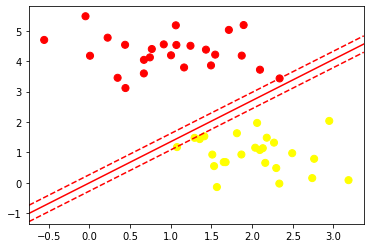

In [13]:
fig, ax = plt.subplots()
ax.scatter(p[:, 0], p[:, 1], c=y, s=50, cmap='autumn')

#xy1 = (min(p[:, 0]), (b_lp.x) - (w1) * min(p[:,0]))

#plt.axline(xy1, xy2, c="r")

w1 = w_pos[0].x - w_neg[0].x
w2 = w_pos[1].x - w_neg[1].x
xy1 = (min(p[:, 0]), (b_lp.x) / w2 - (w1 / w2) * min(p[:,0]))
xy2 = (max(p[:, 0]), (b_lp.x) / w2 - (w1 / w2) * max(p[:,0]))
plt.axline(xy1, xy2, c="r")

xy1 = (min(p[:, 0]), (1 + b_lp.x) / w2 - (w1 / w2) * min(p[:,0]))
xy2 = (max(p[:, 0]), (1 + b_lp.x) / w2 - (w1 / w2) * max(p[:,0]))
plt.axline(xy1, xy2, c="r", ls="--")

xy1 = (min(p[:, 0]), (b_lp.x - 1) / w2 - (w1 / w2) * min(p[:,0]))
xy2 = (max(p[:, 0]), (b_lp.x - 1) / w2 - (w1 / w2) * max(p[:,0]))
plt.axline(xy1, xy2, c="r", ls="--")



w1 = w[0].x
w2 = w[1].x
xy1 = (min(p[:, 0]), (b_qp.x) / w2 - (w1 / w2) * min(p[:,0]))
xy2 = (max(p[:, 0]), (b_qp.x) / w2 - (w1 / w2) * max(p[:,0]))
#plt.axline(xy1, xy2)

xy1 = (min(p[:, 0]), (1 + b_lp.x) / w2 - (w1 / w2) * min(p[:,0]))
xy2 = (max(p[:, 0]), (1 + b_lp.x) / w2 - (w1 / w2) * max(p[:,0]))
#plt.axline(xy1, xy2, c="r", ls="--")

xy1 = (min(p[:, 0]), (b_lp.x - 1) / w2 - (w1 / w2) * min(p[:,0]))
xy2 = (max(p[:, 0]), (b_lp.x - 1) / w2 - (w1 / w2) * max(p[:,0]))
#plt.axline(xy1, xy2, c="r", ls="--")


In [15]:
w1

5.022827792675744

In [14]:
w2

-3.7141838392885025